# Evaluating LLMs with LLMs: FLAN, Mistral-7B, and Claude

> *This notebook was tested on the Python 3 kernel of Amazon SageMaker Studio (Distribution v1.6)*

Automating the evaluation of LLMs is useful (to accelerate prompt engineering and solution optimization), but difficult (because the models output natural language text).

This notebook demonstrates how one "evaluator" model (Anthropic Claude on Amazon Bedrock) can be used to automatically score and compare responses from a range of "candidate" models (FLAN-T5 XL and Mistral 7B) - on an example news text summarization task.

_License information_

    Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
    SPDX-License-Identifier: MIT-0

## Prerequisites

We'll use the following libraries which are not included on SageMaker Studio JupyterLab kernels by default, so need to be installed:

- The [Hugging Face Datasets library](https://huggingface.co/docs/datasets/index), for loading and transforming datasets
- [Seaborn](https://seaborn.pydata.org/) for simple data visualizations

In [ ]:
%pip install "datasets>=2.15,<3" "seaborn>=0.13,<0.14"

You'll also need to **enable access to Anthropic Claude v3 (Sonnet)** in Amazon Bedrock:

1. Select an [AWS Region where the model is available](https://docs.aws.amazon.com/bedrock/latest/userguide/models-regions.html) (which doesn't have to be the same region as you deployed this notebook). For e.g. `us-west-2`
2. [Enable access to the Claude model in that region](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html) through the Amazon Bedrock Console.
3. Grant [Bedrock IAM permissions to your SageMaker notebook execution role](https://docs.aws.amazon.com/bedrock/latest/userguide/api-setup.html#api-using-sage) to be able to invoke the model from here in the notebook.

## Deploy candidate models to Amazon SageMaker Endpoints

This notebook will compare outputs from [two candidate LLMs on Amazon SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/jumpstart-foundation-models-use.html):

- FLAN-T5 XL, and
- Mistral 7B Instruct

> ⚠️ **Note:** Created SageMaker Endpoints are [priced](https://aws.amazon.com/sagemaker/pricing/) by the infrastructure consumed, not the number of requests: So be remember to delete the endpoints you create below, once you're done with testing.

### Option 1: Deploy manually through SageMaker Studio UI

If you'd like, you can deploy these manually through the SageMaker Studio UI and record your configure endpoint names below:

In [ ]:
t5_ep_name = "TODO"  # Enter the name of the SageMaker Endpoint you deployed with Flan-T5
mistral_ep_name = "TODO"  # Enter the name of the SageMaker Endpoint you deployed with Mistral 7B

### Option 2: Deploy automatically via SageMaker Python SDK

Alternatively for a more automatic setup, you can run the below code cells to deploy these models automatically:

In [3]:
from sagemaker.jumpstart.model import JumpStartModel

t5_model_id = "huggingface-text2text-flan-t5-xl"
t5_ep_name = t5_model_id
mistral_model_id = "huggingface-llm-mistral-7b-instruct"
mistral_ep_name = mistral_model_id

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
t5_model = JumpStartModel(model_id=t5_model_id)
t5_predictor = t5_model.deploy(endpoint_name=t5_ep_name, instance_type="ml.g5.4xlarge")

Using model 'huggingface-text2text-flan-t5-xl' with wildcard version identifier '*'. You can pin to version '2.1.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


--------!

In [5]:
mistral_model = JumpStartModel(model_id=mistral_model_id)
mistral_predictor = mistral_model.deploy(
    endpoint_name=mistral_ep_name, instance_type="ml.g5.8xlarge"
)

Using model 'huggingface-llm-mistral-7b-instruct' with wildcard version identifier '*'. You can pin to version '3.0.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


---------!

## Prepare the dataset

We'll explore a text summarization use-case using the [cnn_dailymail dataset](https://huggingface.co/datasets/cnn_dailymail), but only process five samples to save time.

First, load the dataset and show the available partitions and fields:

In [6]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

This dataset demonstrates summarizing news articles into shorter highlights. Let's take a look at one source article as an example:

In [7]:
print(dataset["train"]["article"][0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

This example dataset also includes target "ground truth" summaries for each article, which are **not actually necessary** for the evaluation procedure described below - but we'll calculate and compare metrics on these reference answers too:

In [8]:
print(dataset["train"]["highlights"][0])

Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


To minimize waiting time and cost, we'll demonstrate the process on just a small, randomly-selected subset of this dataset:

In [9]:
import numpy as np

num_to_eval = 5
eval_idxs = np.random.default_rng(42).integers(low=0, high=len(dataset["train"]), size=num_to_eval)
eval_idxs

array([ 25625, 222212, 187935, 126007, 124324])

In [10]:
docs_to_summarize = [dataset["train"]["article"][i] for i in eval_idxs]  # Source docs
gt_sums = [dataset["train"]["highlights"][i] for i in eval_idxs]  # Target summaries

print(len(docs_to_summarize))

5


## Generate candidate summaries

With some sample data loaded, we're ready to try generating some summaries using candidate LLMs for the task.

In this case since the LLMs are deployed on Amazon SageMaker, we'll use the [Predictor API](https://sagemaker.readthedocs.io/en/stable/api/inference/index.html) from the [high-level SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) to invoke them:

### FLAN-T5 model

First we'll configure the SageMaker endpoint and set up a utility function to use it to summarize some text:

> ⚠️ **Note:** If you get an *"Inference Component Name header is required"* error from the below code, you'll need to replace `component_name=None`. Find your T5 endpoint from the *Deployments > Endpoints* menu in SageMaker Studio and click through to view the endpoint details. You should see a "Models" tab with a list of (probably just one) models deployed on the endpoint. Copy that model name and use it as your `component_name` below. For more about how "inference components" enable you to share endpoint infrastructure between multiple models, [see the developer guide](https://docs.amazonaws.cn/en_us/sagemaker/latest/dg/realtime-endpoints-deploy-models.html#deployed-shared-utilization).

In [11]:
import json
import time

import sagemaker
from sagemaker.serializers import JSONSerializer

# Specify the target endpoint:
t5_predictor = sagemaker.predictor.Predictor(
    t5_ep_name,
    serializer=JSONSerializer(),  # This endpoint expects requests in JSON format
    component_name=None,
    # TODO: If required, replace the above with your inference component e.g:
    # component_name="huggingface-text2text-flan-t5-xl-20240419-055102",
)


def summarize_t5(doc: str) -> str:
    """Utility function to query the FLAN-T5 SageMaker endpoint"""
    payload = {
        "inputs": f"Write a short summary for this text: \"{doc}\"",
        "parameters": {
            "max_length": 5000,
            "do_sample": True,
            "top_k": 10,
        },
    }
    response = json.loads(t5_predictor.predict(payload))
    return response[0]["generated_text"].strip()

Next, we can call this function across the sample dataset to generate the FLAN-T5 summaries:

In [12]:
%%time

t5_sums = []
for doc in docs_to_summarize:
    print(".", end="")
    response = summarize_t5(doc)
    t5_sums.append(response)
    time.sleep(2)
print()

print(f"\nExample summary 0:\n{t5_sums[0]}\n")

.....

Example summary 0:
French police arrest man suspected of being new military chief of Basque separatist group ETA in southern France; ETA military leader's alleged predecessor was arrested last month

CPU times: user 38.8 ms, sys: 4.96 ms, total: 43.7 ms
Wall time: 19.1 s


### Mistral 7B model

We can apply the same procedure to the deployed Mistral model to generate another set of candidate summaries:

> ⚠️ **Note:** If you get an *"Inference Component Name header is required"* error from the below code, you'll need to replace `component_name=None`. Find your Mistral endpoint from the *Deployments > Endpoints* menu in SageMaker Studio and click through to view the endpoint details. You should see a "Models" tab with a list of (probably just one) models deployed on the endpoint. Copy that model name and use it as your `component_name` below. For more about how "inference components" enable you to share endpoint infrastructure between multiple models, [see the developer guide](https://docs.amazonaws.cn/en_us/sagemaker/latest/dg/realtime-endpoints-deploy-models.html#deployed-shared-utilization).

In [13]:
import json
import time

import sagemaker
from sagemaker.serializers import JSONSerializer

# Specify the target endpoint:
mistral_predictor = sagemaker.predictor.Predictor(
    mistral_ep_name,
    serializer=JSONSerializer(),  # This endpoint expects requests in JSON format
    component_name=None,
    # TODO: If required, replace the above with your inference component e.g:
    # component_name="huggingface-llm-mistral-7b-instruct-20240423-054202",
)


def summarize_mistral(doc: str) -> str:
    """Utility function to query the Mistral SageMaker endpoint"""
    payload = {
        "inputs": f"\"{doc[:950]}\".\nSummarize the article above:",
        "parameters": {
            "max_new_tokens": 300,
            "return_full_text": False,
        },
    }
    response = json.loads(mistral_predictor.predict(payload))
    return response[0]["generated_text"].strip()

In [14]:
%%time

mistral_sums = []
for doc in docs_to_summarize:
    print(".", end="")
    response = summarize_mistral(doc)
    mistral_sums.append(response)
    time.sleep(2)
print()

print(f"\nExample summary 0:\n{mistral_sums[0]}\n")

.....

Example summary 0:
French police have arrested the suspected new military chief of the Basque separatist group ETA. Aitzol Iriondo Yarza was detained in the southern French village of Gerde with two other ETA suspects. He allegedly headed the ETA commandos who carried out attacks. The suspected overall leader of ETA, Mikel Garikoitz Aspiazu, was arrested in November in southern France. ETA is responsible for over 800 deaths. A Basque businessman was shot and killed last week in northern Spain in an attack blamed on ETA.

CPU times: user 30.9 ms, sys: 9.02 ms, total: 39.9 ms
Wall time: 33 s


## Evaluate the candidates

In this example use-case, *even with* a set of "ideal reference" summaries, the task of comparing the text outputs of these two models is non-trivial and potentially subjective.

While it might be reasonable to manually review the candidate summaries across this small dataset of 5 articles to choose the "best", the effort would quickly become unsustainable for large datasets - or if we wanted to compare a large number of candidate models, prompt templates, inference configurations, and so on.

To scale more effectively, we can consider **using another LLM** to evaluate the candidate results automatically.

It might first seem like this is "checking our own homework" and an unreliable approach, but there are some important reasons it's worth a try:

1. For many tasks, *checking* a solution against a reference is a **cognitively easier task** than *generating* the solution: Which can allow models to recognise their shortcomings even when they failed the original task.
2. (Especially for high-volume use-cases) it might be **economically feasible** to use a more accurate, more expensive, and perhaps slower LLM for offline evaluation - but deploy with a more lightweight and optimized model.
3. **We can (and should) check** how well automated, LLM-evaluated metrics align with a smaller subset of manually-labelled ground truth data on the same examples, to understand how what level of trust can be placed in the automated metrics run on larger datasets.

In this example, we'll use [Anthropic Claude on Amazon Bedrock](https://aws.amazon.com/bedrock/claude/) as the evaluator model and ask it to characterise specific score components that could be compared against human ratings if available:

In [15]:
from string import Template

import boto3  # General-purpose AWS SDK for Python

BEDROCK_REGION = boto3.Session().region_name  # Override this with e.g. "us-east-1" if you need
BEDROCK_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"
EVAL_PROMPT_TEMPLATE = Template("""You will be given a summmary of a news article. Your task is to
evaluate the summary in four dimensions, accuracy, coherence, factuality, and completeness.
Provide a score of 1-5 in each dimension, with 5 being the best score.

Original document: ${doc}

Summary: ${summary}

Evaluation form (scores only):

- Coherence:
- Accuracy:
- Factuality:
- Completeness:
""")

botosess = boto3.Session(region_name=BEDROCK_REGION)
bedrock = botosess.client("bedrock-runtime")


def critique_summary(doc: str, summary: str) -> str:
    """Critique an article summary with Anthropic Claude on Amazon Bedrock"""
    prompt = EVAL_PROMPT_TEMPLATE.substitute(doc=doc, summary=summary)
    response = bedrock.invoke_model(
        modelId=BEDROCK_MODEL_ID,
        body=json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 100,
            "messages": [
                {
                    "role": "user",
                    "content": [{"type": "text", "text": prompt}],
                },
            ],
            "temperature": 0,
        }),
    )
    res_body = json.loads(response["body"].read())
    return res_body["content"][0]["text"]


# Try the function out to check it:
print(f"Document\n--------\n{docs_to_summarize[0]}\n")
print(f"Summary\n-------\n{mistral_sums[0]}\n")
print(f"Critique\n--------\n{critique_summary(docs_to_summarize[0], mistral_sums[0])}")

Document
--------
MADRID, Spain (CNN) -- French police arrested the suspected new military chief of the Basque separatist group ETA on Monday, just three weeks after his alleged predecessor was captured, CNN partner station CNN+ reported. Mikel Garikoitz Aspiazu was captured last month. The suspect, Aitzol Iriondo Yarza, allegedly headed the ETA commandos who carried out attacks. He was detained in the southern French village of Gerde with two other ETA suspects, French police said. The suspected overall leader of ETA -- heading both the military and policy-making, or political, wing -- was arrested November 17, also in southern France, Rubalcaba said last month. That man, Mikel Garikoitz Aspiazu, 35, alias "Txeroki," is wanted in connection with numerous ETA fatal attacks, Rubalcaba said. Since then, a Basque businessman was shot and killed last Wednesday in northern Spain, in an attack authorities blamed on ETA. ETA is blamed for more than 800 deaths in its long fight for Basque inde

Since the evaluator model is also an LLM, it also outputs free-form text. As a result we need one more step to parse our expected metric structure out of the model response - but for a high-quality model that's able to follow your instructions reliably, this shouldn't be too problematic:

In [16]:
%%time

import re  # Regular Expressions
from typing import Dict, List  # Type hints in Python

def parse_critique(critique: str) -> Dict[str, float]:
    """Parse numeric metric values out of a single critique"""
    metrics = {
        "accuracy": r"Accuracy: (\d+)",
        "coherence": r"Coherence: (\d+)",
        "factuality": r"Factuality: (\d+)",
        "completeness": r"Completeness: (\d+)",
    }
    result = {}
    for name, pattern in metrics.items():
        m = re.search(pattern, critique)
        if m is None:
            value = 0.0
        else:
            value = float(m.group(1))
        result[name] = value
    return result


def evaluate_summary(doc: str, summary: str) -> Dict[str, float]:
    return parse_critique(critique_summary(doc, summary))


print(f"Example metrics:\n{evaluate_summary(docs_to_summarize[0], t5_sums[0])}")

Example metrics:
{'accuracy': 5.0, 'coherence': 5.0, 'factuality': 5.0, 'completeness': 3.0}
CPU times: user 5.62 ms, sys: 0 ns, total: 5.62 ms
Wall time: 2.49 s


Let's run these evaluations across all the candidate summary examples:

In [17]:
%%time

print("Evaluating ground truth summaries...")
gt_evals = [evaluate_summary(doc, summ) for doc, summ in zip(docs_to_summarize, gt_sums)]
print("Evaluating FLAN-T5 summaries...")
t5_evals = [evaluate_summary(doc, summ) for doc, summ in zip(docs_to_summarize, t5_sums)]
print("Evaluating Mistral summaries...")
mistral_evals = [evaluate_summary(doc, summ) for doc, summ in zip(docs_to_summarize, mistral_sums)]
print("Done")

Evaluating ground truth summaries...
Evaluating FLAN-T5 summaries...
Evaluating Mistral summaries...
Done
CPU times: user 43.7 ms, sys: 6.47 ms, total: 50.1 ms
Wall time: 30.5 s


## Explore the results

> ⚠️ **Note:** The results presented here, on a tiny dataset with no model tuning or prompt engineering, are for illustrative purposes only and do not represent a comprehensive evaluation of the models tested - even within summarization tasks specifically!

After running the different models' outputs through the evaluator, we can aggregate the results to the dataset level by taking an average across documents - and use these average metrics to compare the performance between models:

We can run and aggregate these metrics across the whole sample dataset to compare the performance of the two candidate models:

In [18]:
import pandas as pd  # For displaying and working with dataframes/tables


def avg_metrics(metrics: List[Dict[str, float]]) -> Dict[str, float]:
    """Take the mean of a dataset of metrics dictionaries"""
    if not len(metrics):
        return {}
    return {
        k: sum(m[k] for m in metrics) / len(metrics)  # Average (mean) across all samples
        for k in metrics[0].keys()  # Assume all eval results include the same metrics
    }


# Display the averages per model:
df = pd.DataFrame(
    [avg_metrics(gt_evals), avg_metrics(t5_evals), avg_metrics(mistral_evals)],
    index=["Ground Truth", "FLAN-T5", "Mistral"],
)
print(f"Average metric scores over sample dataset (n={len(docs_to_summarize)})")
df

Average metric scores over sample dataset (n=5)


,accuracy,coherence,factuality,completeness
Ground Truth,4.8,4.8,5.0,3.4
FLAN-T5,4.8,4.8,5.0,3.2
Mistral,5.0,5.0,5.0,4.0


For a more nuanced insight to how **variable** each model's performance might be, we could visualize the full underlying dataset instead of summarizing by average only:

<Axes: xlabel='metric', ylabel='value'>

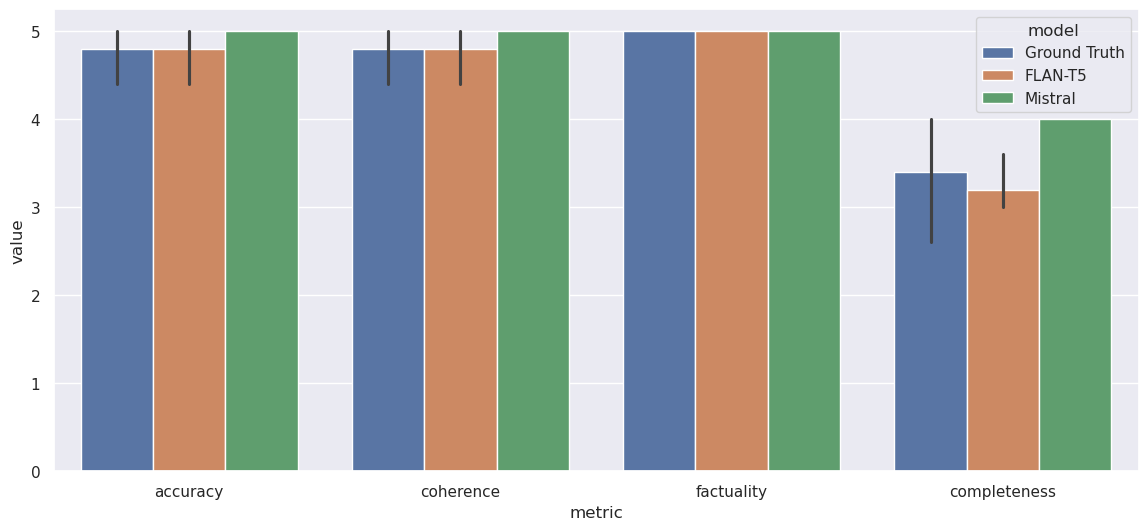

In [19]:
import seaborn as sns

sns.set(rc={"figure.figsize": (14, 6)})  # Improve default chart display size

all_evals = []
for mdl, evals in {"Ground Truth": gt_evals, "FLAN-T5": t5_evals, "Mistral": mistral_evals}.items():
    for e in evals:
        for metric_name, metric_value in e.items():
            # len(all_evals) = #models * #metrics * #documents
            all_evals.append({"metric": metric_name, "value": metric_value, "model": mdl})

sns.barplot(data=pd.DataFrame(all_evals), x="metric", y="value", hue="model")

## Conclusions

In our observed results as configured above, the Claude evaluator found that the **Mistral 7B** model performed marginally better on summarization accuracy than FLAN-T5, and significantly better on summarization completeness - with coherence and factuality already essentially perfect in both models.

Interestingly, Claude reported that Mistral **out-performed the 'ground truth'** target summaries along the target metrics. This kind of evaluation does not intrinsically require a "ground truth", and sensible next steps here would be to manually review some candidate responses to check whether actual human sponsor users' preferences align better with the Mistral responses or the original reference summaries.

What's ultimately important is that the chosen metric(s) for evaluation align well to real business outcomes. LLM-based evaluations allow us to scale out testing to a much broader range of candidate LLMs, prompt templates, and inference configurations than would otherwise be possible - while we can compare the results to manual testing on smaller datasets to build confidence that our scalable, automated metrics align well to the ultimate business objectives.

A range of additional techniques could be considered to further improve alignment between automated metrics and human/business goals, such as:

- Using a **panel of multiple** evaluator models instead of just one "trusted" model, and aggregating the results
- **Prompt engineering** or even **fine-tuning** the evaluator model to align more closely with human/business feedback

## Clean-up

To avoid ongoing charges after you're done experimenting, don't forget to delete the two **SageMaker endpoints** you deployed for this notebook! You can do this from the [AWS Console for Amazon SageMaker](https://console.aws.amazon.com/sagemaker/home?#/endpoints), or the *Deployments > Endpoints* section of the SageMaker Studio UI.